In [2]:
import io
from pathlib import Path 
import zipfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.core.pylabtools import figsize

figsize(8, 8)

In [3]:
datapath = Path("/media/hemu/Data/Markets/FX/truefx/GBPJPY-zip")



In [4]:
def read_and_parse_truefx(filepath):
    df = pd.read_csv(filepath, header=None, parse_dates=True)
    df.columns = ('asset', 'timestamp', 'bid', 'ask')
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    return df.drop('asset', axis=1).set_index('timestamp')

In [5]:
files = list(datapath.iterdir())
print(len(files))

df = read_and_parse_truefx(files[0])

125


In [6]:
df[['ask', 'bid']].mean()

ask    146.518591
bid    146.494028
dtype: float64

/home/hemu/miniconda3/envs/madigan/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


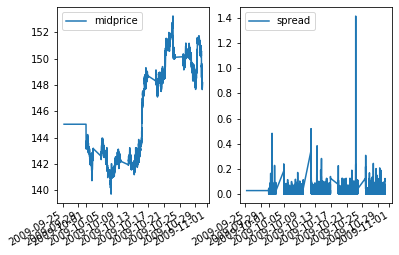

In [7]:
%matplotlib inline

fig, ax = plt.subplots(1, 2, sharex=True)
ax[0].plot(df[['ask', 'bid']].mean(axis=1), label='midprice')
ax[1].plot(df['ask'] - df['bid'], label='spread')
ax[0].legend()
ax[1].legend()
fig.autofmt_xdate()

In [24]:
# https://jeremykun.com/2015/08/06/cech-vietris-rips-complex/
from itertools import combinations

def naiveVR(points: np.ndarray, eps: float):
    vr_complex = [(x, y) for x, y in combinations(points, 2) \
                  if np.linalg.norm(x-y) < 2*eps]
    return np.array(vr_complex)

In [41]:
x = df[['ask', 'bid']].mean(axis=1)
points = x[100:1000]

vr = naiveVR(points, 0.5)

In [42]:
import networkx

ModuleNotFoundError: No module named 'networkx'

In [ ]:
len(vr), vr

In [43]:
points

timestamp
2009-10-01 00:01:27.455    143.8520
2009-10-01 00:01:27.949    143.8515
2009-10-01 00:01:28.538    143.8500
2009-10-01 00:01:28.677    143.8495
2009-10-01 00:01:28.802    143.8485
                             ...   
2009-10-01 00:23:05.921    143.6700
2009-10-01 00:23:05.923    143.6790
2009-10-01 00:23:07.693    143.6795
2009-10-01 00:23:21.443    143.6790
2009-10-01 00:23:26.305    143.6795
Length: 900, dtype: float64

404550 352


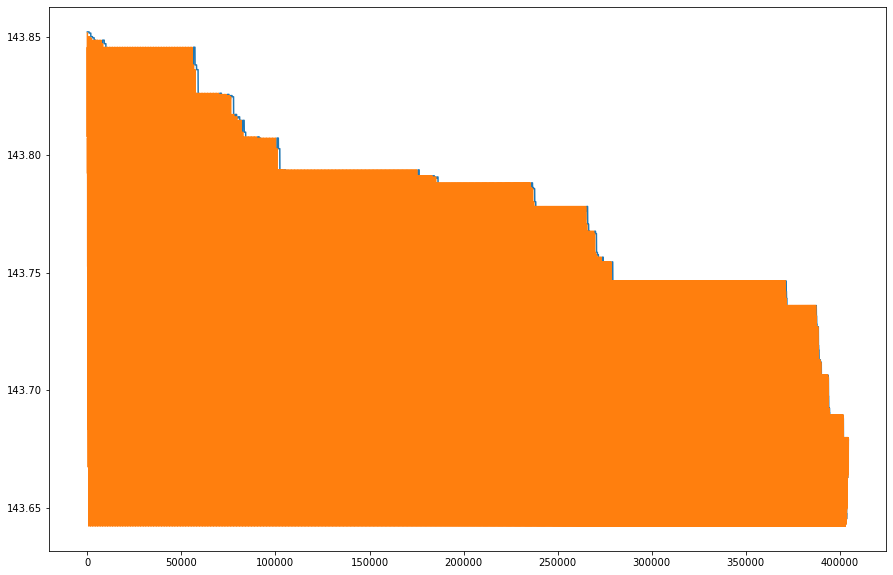

In [67]:
plt.plot(vr)


404550 352


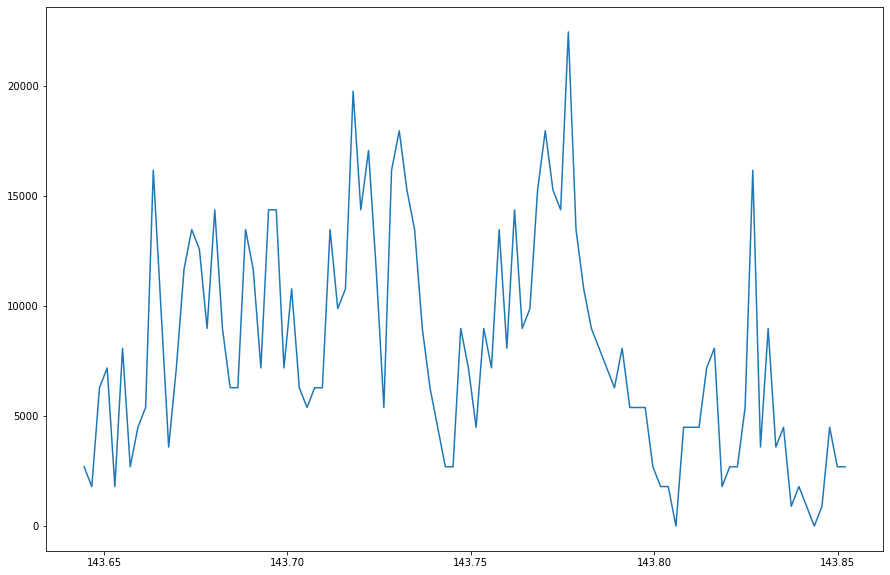

In [75]:

print(len(vr), len(np.unique(vr)))
hist = np.histogram(vr, bins=100)
plt.plot(hist[1][1:], hist[0])

In [47]:
# https://www.sthu.org/blog/13-perstopology-peakdetection/index.html#fnref:universality

class Peak:
    def __init__(self, startidx):
        self.born = self.left = self.right = startidx
        self.died = None

    def get_persistence(self, seq):
        return float("inf") if self.died is None else seq[self.born] - seq[self.died]

def get_persistent_homology(seq):
    peaks = []
    # Maps indices to peaks
    idxtopeak = [None for s in seq]
    # Sequence indices sorted by values
    indices = range(len(seq))
    indices = sorted(indices, key = lambda i: seq[i], reverse=True)

    # Process each sample in descending order
    for idx in indices:
        lftdone = (idx > 0 and idxtopeak[idx-1] is not None)
        rgtdone = (idx < len(seq)-1 and idxtopeak[idx+1] is not None)
        il = idxtopeak[idx-1] if lftdone else None
        ir = idxtopeak[idx+1] if rgtdone else None

        # New peak born
        if not lftdone and not rgtdone:
            peaks.append(Peak(idx))
            idxtopeak[idx] = len(peaks)-1

        # Directly merge to next peak left
        if lftdone and not rgtdone:
            peaks[il].right += 1
            idxtopeak[idx] = il

        # Directly merge to next peak right
        if not lftdone and rgtdone:
            peaks[ir].left -= 1
            idxtopeak[idx] = ir

        # Merge left and right peaks
        if lftdone and rgtdone:
            # Left was born earlier: merge right to left
            if seq[peaks[il].born] > seq[peaks[ir].born]:
                peaks[ir].died = idx
                peaks[il].right = peaks[ir].right
                idxtopeak[peaks[il].right] = idxtopeak[idx] = il
            else:
                peaks[il].died = idx
                peaks[ir].left = peaks[il].left
                idxtopeak[peaks[ir].left] = idxtopeak[idx] = ir

    # This is optional convenience
    return sorted(peaks, key=lambda p: p.get_persistence(seq), reverse=True)

In [48]:
peak_idxs = [p.born for p in get_persistent_homology(points)]
len(peak_idxs)

228

900


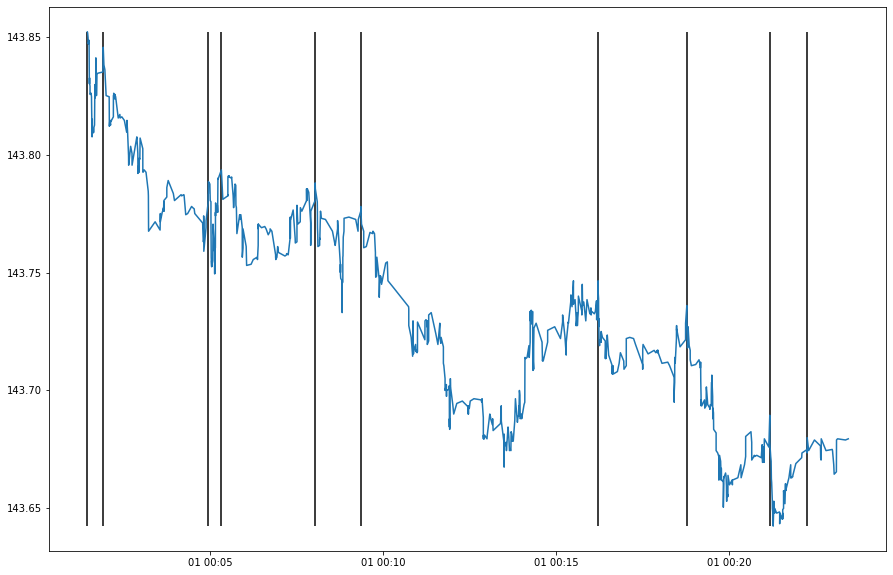

In [79]:
%matplotlib inline
figsize(15, 10)
plt.plot(points)
# plt.plot(1/points)
idx = points.index[peak_idxs[:10]]
plt.vlines(idx,  points.min(), points.max())

print(len(points))